In [1]:
import texas_hold_em_utils.card as card
import texas_hold_em_utils.deck as deck
import texas_hold_em_utils.game as game
import texas_hold_em_utils.player as player
import pandas as pd

In [2]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
import os
import sqlalchemy

conn = sqlalchemy.create_engine(os.getenv("SUPABASE_CONN_STRING")).connect()

In [9]:
game1 = game.Game(2)
game1.players = [player.SimplePlayer(0), player.SimplePlayer(1)]
game1.deal()
game1.get_bets()
game1.flop()
game1.get_bets()
game1.turn()
game1.get_bets()
game1.river()
game1.get_bets()
winners = game1.determine_round_winners()

In [3]:
def simulate_random_game(num_players):
    game1 = game.Game(num_players)
    game1.players = [player.SimplePlayer(i) for i in range(num_players)]
    game1.deal()
    game1.get_bets()
    game1.flop()
    game1.get_bets()
    game1.turn()
    game1.get_bets()
    game1.river()
    game1.get_bets()
    winners = game1.determine_round_winners()
    df = pd.DataFrame(data={
        "flop_1": [game1.community_cards[0].__str__()],
        "flop_2": [game1.community_cards[1].__str__()],
        "flop_3": [game1.community_cards[2].__str__()],
        "turn": [game1.community_cards[3].__str__()],
        "river": [game1.community_cards[4].__str__()],
        "winners": ", ".join([f"player_{winner.position}" for winner in winners])
    })
    for i, player1 in enumerate(game1.players):
        df[f"player_{i}_card_1"] = player1.hand_of_two.cards[0].__str__()
        df[f"player_{i}_card_2"] = player1.hand_of_two.cards[1].__str__()
        df[f"player_{i}_hand_rank"] = player1.hand_of_five.hand_rank
    return df

In [25]:
df = None
for i in range(10):
    if df is None:
        df = simulate_random_game(4)
    else:
        df = pd.concat([df, simulate_random_game(4)])

In [28]:
for num_players in range(3, 10):
    print(num_players)

3
4
5
6
7
8
9


In [6]:

for num_players in range(7, 10):
    for i in range(1000):
        data_df = None
        for j in range(1000):
            if data_df is None:
                data_df = simulate_random_game(num_players)
            else:
                data_df = pd.concat([data_df, simulate_random_game(num_players)])
        data_df.to_sql(f"random_games_for_{num_players}_players", conn, if_exists="append", schema="poker")
        conn.commit()

MemoryError: 

In [5]:
conn.commit()
conn.close()

In [7]:
conn = sqlalchemy.create_engine(os.getenv("SUPABASE_CONN_STRING")).connect()

In [19]:
two_player_data = pd.read_sql(sqlalchemy.text("SELECT * FROM poker.two_player_game_odds"), conn)

In [20]:
two_player_data["card_1_rank"] = two_player_data["card_1"].apply(lambda x: card.Card().ranks.index(x[:2].strip()))
two_player_data["card_1_suit"] = two_player_data["card_1"].apply(lambda x: card.Card().suits.index(x[5:].strip()))
two_player_data["card_2_rank"] = two_player_data["card_2"].apply(lambda x: card.Card().ranks.index(x[:2].strip()))
two_player_data["card_2_suit"] = two_player_data["card_2"].apply(lambda x: card.Card().suits.index(x[5:].strip()))



In [21]:
card_1_rank = 12
suited = True
card_2_rank = 11

relevant_data = two_player_data[(two_player_data["card_1_rank"] == card_1_rank) & (two_player_data["card_2_rank"] == card_2_rank) & ((two_player_data["card_1_suit"] == two_player_data["card_2_suit"]) == suited)]

df = pd.DataFrame(data={"card_1_rank": [card_1_rank], "suited": [suited], "card_2_rank": [card_2_rank], "win_rate": [relevant_data["win_rate"].mean()]})
df = df.sort_values(by="win_rate", ascending=False)
df

,card_1_rank,suited,card_2_rank,win_rate
0,12,True,11,0.69321


In [22]:
df = None
for card_1_rank in range(13):
    for card_2_rank in range(13):
        for suited in [True, False]:
            relevant_data = two_player_data[(two_player_data["card_1_rank"] == card_1_rank) & (two_player_data["card_2_rank"] == card_2_rank) & ((two_player_data["card_1_suit"] == two_player_data["card_2_suit"]) == suited)]
            if len(relevant_data) > 0:
                new_df = pd.DataFrame(data={"card_1_rank": [card_1_rank], "suited": [suited], "card_2_rank": [card_2_rank], "win_rate": [relevant_data["win_rate"].mean()]})
                if df is None:
                    df = new_df
                else:
                    df = pd.concat([df, new_df])

In [23]:
df = df.sort_values(by="win_rate", ascending=False)
df['rank'] = range(len(df))

In [24]:
df['percentile'] = (len(df) - df['rank']) / len(df)

In [25]:
from texas_hold_em_utils.sklansky import sklansky_rank

df['sklansky'] = df.apply(lambda x: sklansky_rank(card.Card().from_ints(x["card_1_rank"], 0), card.Card().from_ints(x["card_2_rank"], 0 if x['suited'] else 1)), axis=1)

In [26]:
avgs = df.groupby("sklansky")["win_rate"].mean()

cutoffs = []
for rank in range(8):
    cutoffs.append((avgs.iloc[rank] + avgs.iloc[rank + 1]) / 2)
    
cutoffs

[0.7201325382815115,
 0.649653723811387,
 0.6122581094082393,
 0.5812130832678524,
 0.556856010906333,
 0.5265988991531945,
 0.4882504494029658,
 0.4609693372555661]

In [27]:
def get_modified_sklansky(win_rate):
    for i in range(len(cutoffs)):
        if win_rate >= cutoffs[i]:
            return i + 1
    return 9

In [28]:
df['modified_sklansky'] = df['win_rate'].apply(get_modified_sklansky)

In [29]:
from texas_hold_em_utils.sklansky import sklansky_playable_position
df['sklansky_position'] = df.apply(lambda x: sklansky_playable_position(x["sklansky"]), axis=1)

In [30]:
df['modified_sklansky_position'] = df.apply(lambda x: sklansky_playable_position(x["modified_sklansky"]), axis=1)

In [31]:
import matplotlib.pyplot as plt

<AxesSubplot:>

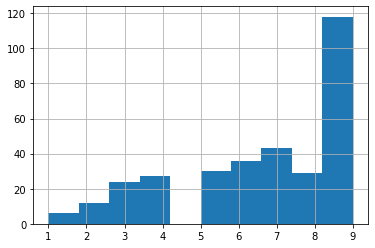

In [32]:
df['modified_sklansky'].hist()

In [33]:
df.to_sql("two_player_hand_odds", conn, if_exists="replace", schema="poker")

325